# Intro to 4D-STEM data: calibration

There are many calibrations that can be performed on 4DSTEM data.  Which ones are necessary depends on the data and the analysis being performed.  The most typical calibrations are

- the origin
- the ellipticity
- the pixel size

In this notebook we'll perform these three calibration.

There are various methods for performing calibrations.  Here we'll calibrate using the Bragg vectors detected in the previous notebook.


### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Ben Savitzky (bhsavitzky@lbl.gov)
- Steve Zeltmann (steven.zeltmann@berkeley.edu)
- Stephanie Ribet (sribet@u.northwestern.edu)
- Alex Rakowski (arakowski@lbl.gov)
- Colin Ophus (clophus@lbl.gov)


Updated 11/1/2023, version 0.14.8

## Set up the environment

In [1]:
import py4DSTEM
from py4DSTEM.visualize import show
py4DSTEM.__version__

'0.14.8'

---
# Download the tutorial data <a class="anchor" id="part_00"></a>

You can download the tutorial dataset here: (501 megabytes)
* [Simulated single crystal and polycrystalline gold](https://drive.google.com/file/d/1m-jfXnStFWq0jo_hPY-3OtYaO62wHP3A/view?usp=drive_link)

# Load data

Load
- the same datacube as in the previous notebook, and 
- the results from basics_02 (disk detection)

In [2]:
# Set the filepaths

dirpath = "/Users/Ben/work/data/py4DSTEM_sampleData/calibration_simulatedAuNanoplatelet/"

filepath_data = dirpath + "sim_Au_data_all_binned.h5"
filepath_basics_01 = dirpath + 'analysis_basics_01.h5'
filepath_basics_02 = dirpath + 'analysis_basics_02.h5'

In [3]:
# Load the datacube

datacube = py4DSTEM.read(
    filepath = filepath_data,
    datapath = '4DSTEM_simulation/4DSTEM_polyAu'
)

datacube

DataCube( A 4-dimensional array of shape (100, 84, 125, 125) called '4DSTEM_polyAu',
          with dimensions:

              Rx = [0,1,2,...] pixels
              Ry = [0,1,2,...] pixels
              Qx = [0,1,2,...] pixels
              Qy = [0,1,2,...] pixels
)

In [4]:
# Load the prior analysis

basics_02 = py4DSTEM.read(
    filepath_basics_02
)

basics_02.tree()

Reading PointListArray: 100%|█████████| 8400/8400 [00:02<00:00, 3203.15PointList/s]

/
|---braggvectors
|---probe


# Examine the Bragg vectors

In [5]:
# Let's assign the bragg vectors a variable for convenience

braggpeaks = basics_02.tree('braggvectors')
braggpeaks

BraggVectors( A (100, 84)-shaped array of lists of bragg vectors )

In [6]:
# Data can be retrieved from BraggVectors instances in two places: .raw, and .cal
# Let's look at .raw first:

braggpeaks.raw

RawVectorGetter( Retrieves raw bragg vectors. Get vectors for scan position x,y with [x,y]. )

In [7]:
braggpeaks.raw[0,0]

BVects( A set of 8 bragg vectors. Access data with .qx, .qy, .I, or .data.)

In [8]:
print(braggpeaks.raw[0,0].qx)
print()
print(braggpeaks.raw[0,0].qy)
print()
print(braggpeaks.raw[0,0].I)

[ 63.58021024  82.08166146 116.53469493  45.63953488  67.3943984
  81.48183316  35.42283423  17.74556952]

[ 63.90056358  47.55687689  81.09100871  80.0095008  107.40693419
  78.85904086  39.36417295  18.82496754]

[1454.39439786   32.54784359   30.90921729   30.58789201   21.7374393
   14.21836474    8.90131618    8.3125159 ]


In [9]:
# The .data property gives us everything (positions and intensities) in a single numpy array.
# It's a structured array, meaning it has a 'dtype' containing several fields,
# each with their own datatype

braggpeaks.raw[0,0].data

array([( 63.58021024,  63.90056358, 1454.39439786),
       ( 82.08166146,  47.55687689,   32.54784359),
       (116.53469493,  81.09100871,   30.90921729),
       ( 45.63953488,  80.0095008 ,   30.58789201),
       ( 67.3943984 , 107.40693419,   21.7374393 ),
       ( 81.48183316,  78.85904086,   14.21836474),
       ( 35.42283423,  39.36417295,    8.90131618),
       ( 17.74556952,  18.82496754,    8.3125159 )],
      dtype=[('qx', '<f8'), ('qy', '<f8'), ('intensity', '<f8')])

In [10]:
braggpeaks.raw[0,0].data['qx']

array([ 63.58021024,  82.08166146, 116.53469493,  45.63953488,
        67.3943984 ,  81.48183316,  35.42283423,  17.74556952])

In [11]:
# The calibrated vectors at .cal have the same interface
# The only difference is that these vectors are transformed before
# being returned, where the transformation is determined
# by the BraggVector's calibration state

braggpeaks.cal

CalibratedVectorGetter( Retrieves calibrated Bragg vectors. Get vectors for scan position x,y with [x,y].
                        Set which calibrations to apply with braggvectors.setcal(...). )

In [12]:
# We haven't made any calibration measurements yet, and none
# were retrieved from microscopy metadata (like pixel sizes),
# so currently no calibrations are applied and the .cal and
# .raw vectors are identical.

braggpeaks.cal[0,0].data

array([( 63.58021024,  63.90056358, 1454.39439786),
       ( 82.08166146,  47.55687689,   32.54784359),
       (116.53469493,  81.09100871,   30.90921729),
       ( 45.63953488,  80.0095008 ,   30.58789201),
       ( 67.3943984 , 107.40693419,   21.7374393 ),
       ( 81.48183316,  78.85904086,   14.21836474),
       ( 35.42283423,  39.36417295,    8.90131618),
       ( 17.74556952,  18.82496754,    8.3125159 )],
      dtype=[('qx', '<f8'), ('qy', '<f8'), ('intensity', '<f8')])

In [13]:
# You can check the current calibration state

braggpeaks.calstate

{'center': False, 'ellipse': False, 'pixel': False, 'rotate': False}

In [14]:
# The calibration state should update automatically as new calibrations measurements
# are taken.  You can also override these and set which calibrations you want applied
# when .cal is used with the .setcal method

braggpeaks.setcal?

Signature: braggpeaks.setcal(center=None, ellipse=None, pixel=None, rotate=None)
Docstring:
Calling

    >>> braggvectors.setcal(
    >>>     center = bool,
    >>>     ellipse = bool,
    >>>     pixel = bool,
    >>>     rotate = bool,
    >>> )

sets the calibrations that will be applied to vectors subsequently
retrieved with

    >>> braggvectors.cal[ scan_x, scan_y ]

Any arguments left as `None` will be automatically set based on
the calibration measurements available.
File:      ~/work/ncem_projects/py4DSTEM/py4DSTEM/braggvectors/braggvectors.py
Type:      method

In [15]:
# Calling .setcal method with no arguments are supplied sets the calibration state
# based on what's available in the dataset's Calibration metadata (i.e. at .calibation)

braggpeaks.setcal()

In [16]:
# All the calibrations are still set to False because we haven't performed
# any calibration measurements yet!

braggpeaks.calstate

{'center': False, 'ellipse': False, 'pixel': False, 'rotate': False}

In [17]:
braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:      1
             R_pixel_size:      1
             Q_pixel_units:     pixels
             R_pixel_units:     pixels
             QR_flip:           False
             _root_treepath:    
             probe_semiangle:   5.14092564018049
             qx0_mean:          63.778138394869096
             qy0_mean:          63.53875683492835
)

In [18]:
# If we try to set the braggvector's calibration state to perform a transformation
# for which is can't find the needed measurement in the Calibration metadata, it
# raises an error

braggpeaks.setcal(
    center = True,       # This can't be True without first setting the origin position!
    ellipse = False,
    pixel = False,
    rotate = False
)

AssertionError: Requested calibration not found

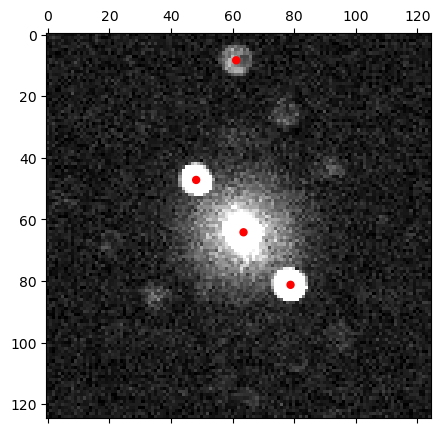

In [19]:
# Let's confirm that the raw vectors represent the positions of
# detected bragg disks in a sample diffraction pattern

dp = datacube[10,20]
v = braggpeaks.raw[10,20]

show(
    dp,
    points = {
        'x' : v.qx,
        'y' : v.qy,
    }
)

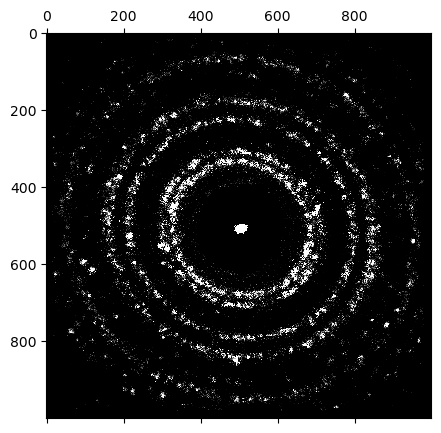

In [20]:
# compute the bragg vector map

bvm = braggpeaks.histogram(
    mode='raw',
    sampling = 8,
)

show(bvm)

In [21]:
# The bragg vector map is another py4DSTEM class which contains various self-descriptive metadata items

bvm

BraggVectorMap( A 2-dimensional array of shape (1000, 1000) called '2Dhist_braggvectors_raw_s=8',
                with dimensions:

                    dim0 = [0.0,0.125,0.25,...] pixels
                    dim1 = [0.0,0.125,0.25,...] pixels
)

In [22]:
print(bvm.origin)
print(bvm.pixelsize)
print(bvm.pixelunits)

(0, 0)
0.125
pixels


In [23]:
bvm.dims[0]

array([  0.   ,   0.125,   0.25 ,   0.375,   0.5  ,   0.625,   0.75 ,
         0.875,   1.   ,   1.125,   1.25 ,   1.375,   1.5  ,   1.625,
         1.75 ,   1.875,   2.   ,   2.125,   2.25 ,   2.375,   2.5  ,
         2.625,   2.75 ,   2.875,   3.   ,   3.125,   3.25 ,   3.375,
         3.5  ,   3.625,   3.75 ,   3.875,   4.   ,   4.125,   4.25 ,
         4.375,   4.5  ,   4.625,   4.75 ,   4.875,   5.   ,   5.125,
         5.25 ,   5.375,   5.5  ,   5.625,   5.75 ,   5.875,   6.   ,
         6.125,   6.25 ,   6.375,   6.5  ,   6.625,   6.75 ,   6.875,
         7.   ,   7.125,   7.25 ,   7.375,   7.5  ,   7.625,   7.75 ,
         7.875,   8.   ,   8.125,   8.25 ,   8.375,   8.5  ,   8.625,
         8.75 ,   8.875,   9.   ,   9.125,   9.25 ,   9.375,   9.5  ,
         9.625,   9.75 ,   9.875,  10.   ,  10.125,  10.25 ,  10.375,
        10.5  ,  10.625,  10.75 ,  10.875,  11.   ,  11.125,  11.25 ,
        11.375,  11.5  ,  11.625,  11.75 ,  11.875,  12.   ,  12.125,
        12.25 ,  12.

# Calibrate the origin

We'll calibrate the origin in two steps:

- measure the origin position using the brightest disk from the disk detection
- fit a plane to those measurements

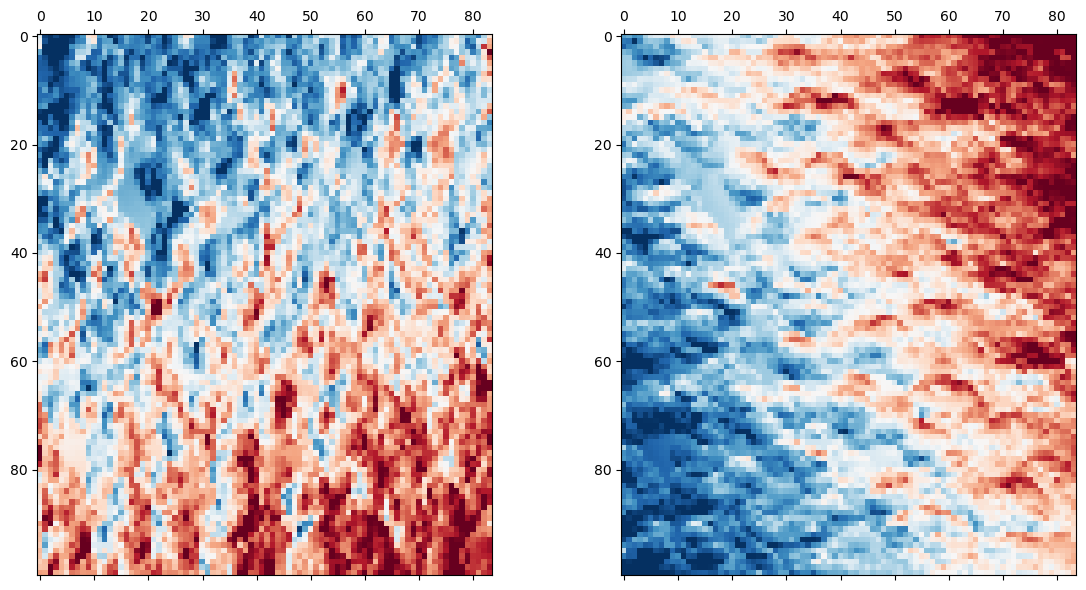

In [24]:
# Measure the origin

qx0_meas,qy0_meas,mask_meas = braggpeaks.measure_origin()

show(
    [qx0_meas,qy0_meas],
    cmap = 'RdBu',
    mask = mask_meas
)

In [25]:
# Note that braggpeaks.measure_origin added its results to the Calibration metadata

braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:       1
             R_pixel_size:       1
             Q_pixel_units:      pixels
             R_pixel_units:      pixels
             QR_flip:            False
             _root_treepath:     
             probe_semiangle:    5.14092564018049
             qx0_mean:           63.778138394869096
             qy0_mean:           63.53875683492835
             qx0_meas:           2D-array
             qy0_meas:           2D-array
             origin_meas_mask:   2D-array
)

In [26]:
# Here's how to retrieve the data:

braggpeaks.calibration.get_origin_meas()

(array([[63.58021024, 64.25119235, 64.91198799, ..., 64.03981684,
         63.7215936 , 63.34478745],
        [63.509762  , 64.19766152, 64.45275188, ..., 63.56969273,
         63.61863342, 63.17939845],
        [63.4338571 , 64.39906305, 64.79101881, ..., 63.69532093,
         62.84943981, 63.12730501],
        ...,
        [63.25746186, 63.1974173 , 62.89609664, ..., 62.8275674 ,
         62.95912494, 62.84115051],
        [63.226513  , 63.21624988, 62.5627516 , ..., 62.86529869,
         62.94608393, 62.74614802],
        [63.11769725, 63.12796005, 62.57314713, ..., 63.06876031,
         62.85655899, 62.80773111]]),
 array([[63.90056358, 63.84003397, 63.9715363 , ..., 61.51366318,
         61.54615257, 61.47016451],
        [64.09332653, 64.14151752, 64.45114567, ..., 61.05712077,
         61.79548549, 61.83596091],
        [64.23700423, 64.03726387, 63.98788789, ..., 61.54618722,
         61.14121606, 61.6765414 ],
        ...,
        [64.6679251 , 64.43236471, 64.84058417, ..., 6

In [27]:
# These arrays are identical to the ones we just found

print( braggpeaks.calibration.get_origin_meas()[0] is qx0_meas )
print( braggpeaks.calibration.get_origin_meas()[1] is qy0_meas )

True
True


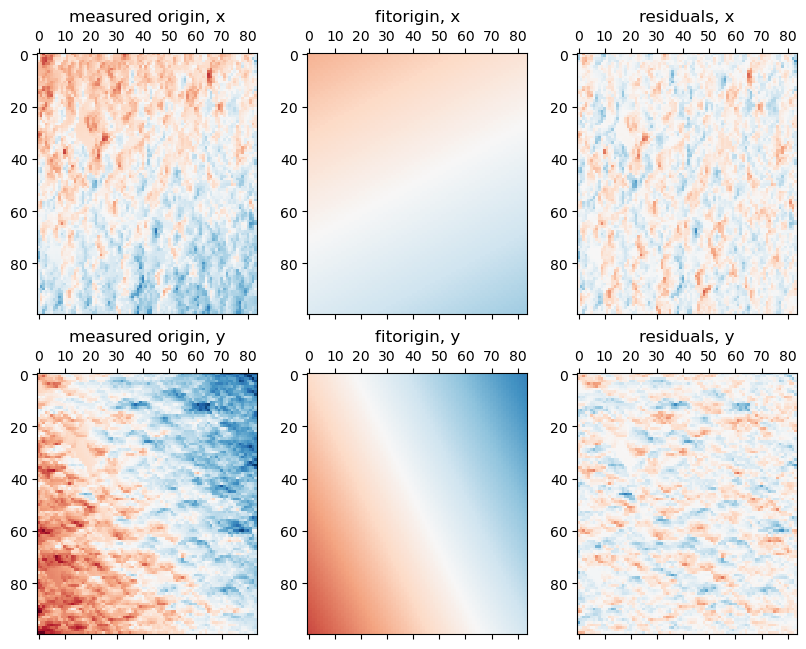

In [28]:
# Fit a plane to the origins

qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = braggpeaks.fit_origin()

In [29]:
# The fit origins now live in the calibration metadata as 'qx0','qy0'

braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:       1
             R_pixel_size:       1
             Q_pixel_units:      pixels
             R_pixel_units:      pixels
             QR_flip:            False
             _root_treepath:     
             probe_semiangle:    5.14092564018049
             qx0_mean:           63.47416802294156
             qy0_mean:           63.22499601104463
             qx0_meas:           2D-array
             qy0_meas:           2D-array
             origin_meas_mask:   2D-array
             qx0:                2D-array
             qx0_shift:          2D-array
             qy0:                2D-array
             qy0_shift:          2D-array
)

In [30]:
# The calibration state of our BraggVectors has automatically updated

braggpeaks.calstate

{'center': True, 'ellipse': False, 'pixel': False, 'rotate': False}

In [31]:
# and calling .cal now gives us the centered vector positions

braggpeaks.cal[0,0].data

array([( -0.62339173,   0.29803979, 1454.39439786),
       ( 17.87805949, -16.0456469 ,   32.54784359),
       ( 52.33109295,  17.48848492,   30.90921729),
       (-18.56406709,  16.40697701,   30.58789201),
       (  3.19079642,  43.8044104 ,   21.7374393 ),
       ( 17.27823119,  15.25651707,   14.21836474),
       (-28.78076774, -24.23835084,    8.90131618),
       (-46.45803245, -44.77755625,    8.3125159 )],
      dtype=[('qx', '<f8'), ('qy', '<f8'), ('intensity', '<f8')])

In [32]:
braggpeaks.raw[0,0].data

array([( 63.58021024,  63.90056358, 1454.39439786),
       ( 82.08166146,  47.55687689,   32.54784359),
       (116.53469493,  81.09100871,   30.90921729),
       ( 45.63953488,  80.0095008 ,   30.58789201),
       ( 67.3943984 , 107.40693419,   21.7374393 ),
       ( 81.48183316,  78.85904086,   14.21836474),
       ( 35.42283423,  39.36417295,    8.90131618),
       ( 17.74556952,  18.82496754,    8.3125159 )],
      dtype=[('qx', '<f8'), ('qy', '<f8'), ('intensity', '<f8')])

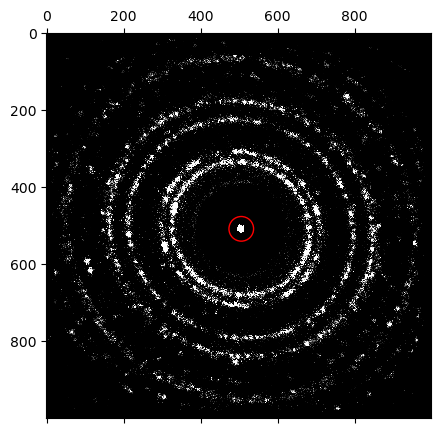

In [33]:
# Now that we've calibrated the center positions, we can re-compute
# the Bragg vector map, this time with the center correction applied

sampling = 8

# compute
bvm = braggpeaks.histogram(
    #mode='cal',             # 'cal' is the default mode, so this line can be included or left out
    sampling = sampling,
)

# show
# overlay a circle around the center for visualization purposes
show(
    bvm,
    circle={
        'center' : bvm.origin,   # the centered BVM knows where its origin is 
        'R' : 4*sampling,
        'fill' : False,
        'linewidth' : 1
    },
    #vmax=0.9
)

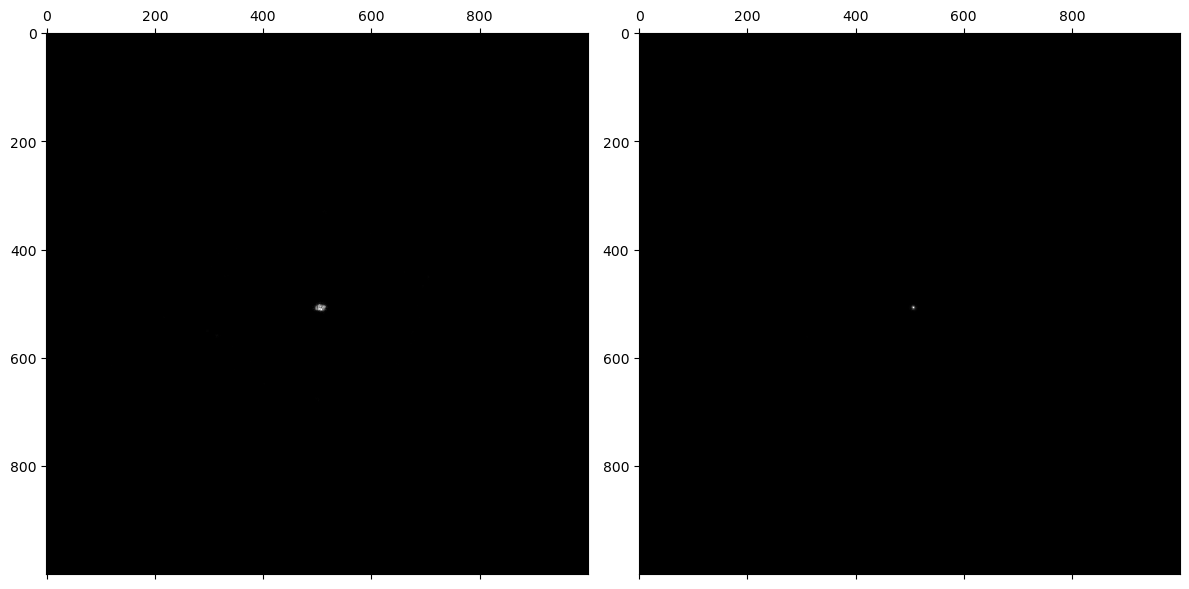

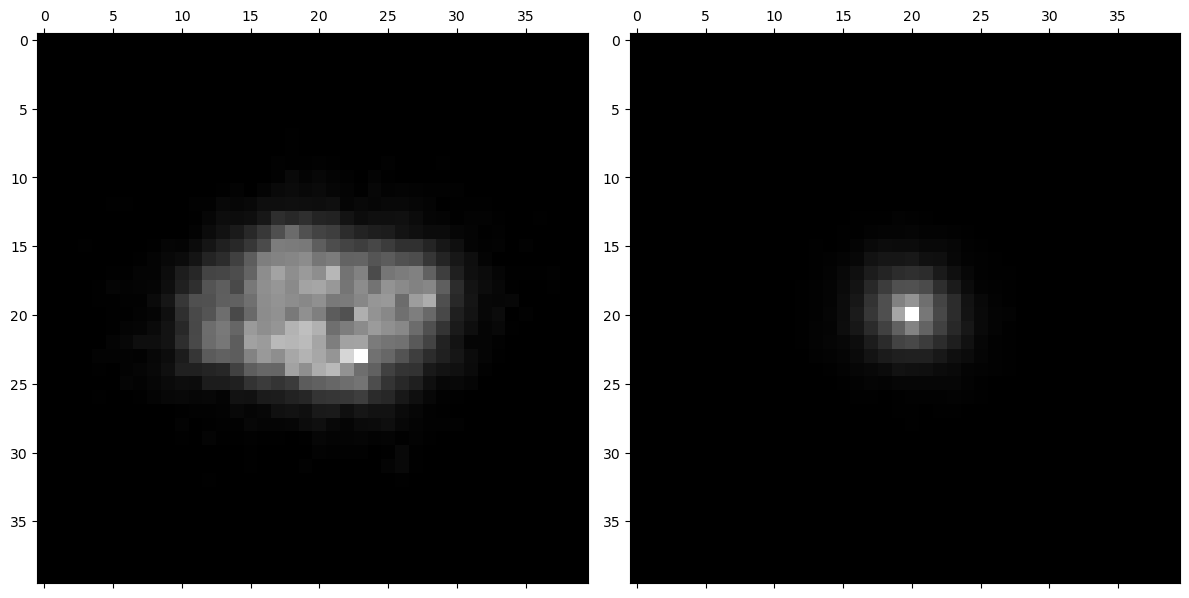

In [34]:
# Compare this to the uncalibrated BVM - much better!

# compute raw vs. centered
bvm_r = braggpeaks.histogram( mode='raw', sampling=sampling )
bvm_c = braggpeaks.histogram( mode='cal', sampling=sampling )

# show
show( [bvm_r, bvm_c] ,vmax=0.999999)

# show, zooming in on origin
L = 20
x,y = bvm_c.origin
import numpy as np
x0,xf = np.round([x-L,x+L]).astype(int)
y0,yf = np.round([y-L,y+L]).astype(int)

show(
    [
    bvm_r[x0:xf,y0:yf],
    bvm_c[x0:xf,y0:yf]
    ],
    vmax=0.999999
)

In [35]:
# This output is fun.  What's going on here?

print(bvm_c.pixelsize)
print(bvm_c.pixelunits)

0.125
pixels


# Calibrate the ellipticity

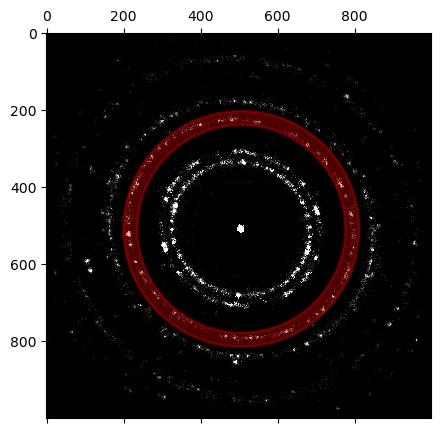

In [36]:
# Select an annular region in which to perform a fit
# The ideal is a single, isolated ring of peaks

#q_range = (336, 384)
q_range = (270, 306)

py4DSTEM.show(
    bvm_c,
    cmap='gray',
    intensity_range='absolute',
    vmin=0,
    vmax=1e2,
    annulus={
        'center':bvm_c.origin,
        'radii': q_range,'fill':True,'color':'r','alpha':0.3}
)

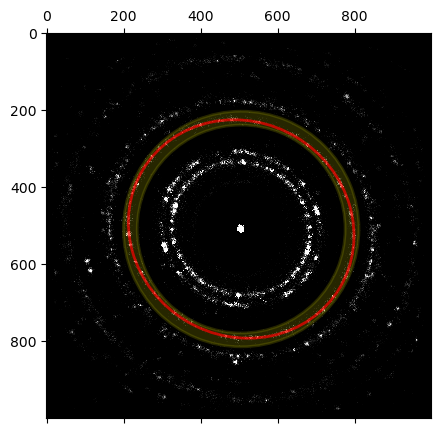

In [37]:
# Fit the elliptical distortions
p_ellipse = py4DSTEM.process.calibration.fit_ellipse_1D(
    bvm_c,
    center = bvm_c.origin,
    fitradii = q_range,
)

# plot the fit
py4DSTEM.visualize.show_elliptical_fit(
    bvm_c,
    q_range,
    p_ellipse,
    cmap='gray',
    intensity_range='absolute',
    vmin=0,
    vmax=1e2,
)

In [38]:
p_ellipse

(508.2368528667467,
 505.53083891476956,
 298.1941924997993,
 278.2326703781001,
 -2.1139796310061887)

In [39]:
# The elliptical parameters are not automatically added to the calibration metadata,
# (to allow inspection of the fit to ensure it's accurate), so need to be added manually
# once a good fit is found. Like so:

braggpeaks.calibration.set_p_ellipse(p_ellipse)

In [40]:
# Note that the code above only adds (a,b,theta) to the calibration metadata; the origin needs to
# be calibrated separately, as we did above 

braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:       1
             R_pixel_size:       1
             Q_pixel_units:      pixels
             R_pixel_units:      pixels
             QR_flip:            False
             _root_treepath:     
             probe_semiangle:    5.14092564018049
             qx0_mean:           63.47416802294156
             qy0_mean:           63.22499601104463
             qx0_meas:           2D-array
             qy0_meas:           2D-array
             origin_meas_mask:   2D-array
             qx0:                2D-array
             qx0_shift:          2D-array
             qy0:                2D-array
             qy0_shift:          2D-array
             a:                  298.1941924997993
             b:                  278.2326703781001
             theta:              -2.1139796310061887
)

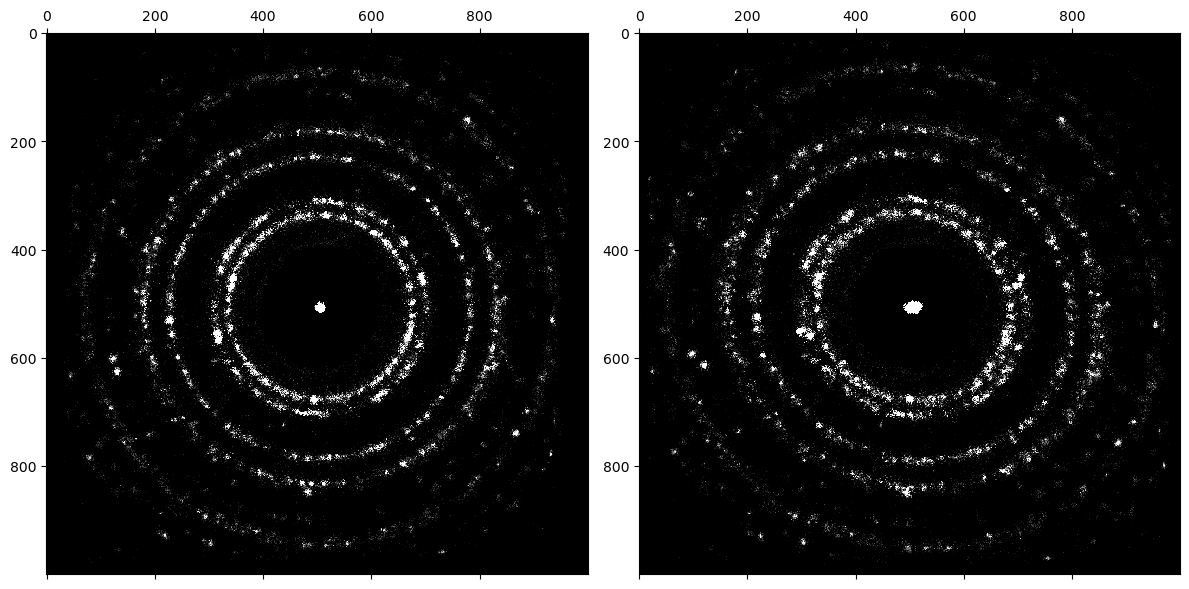

In [41]:
# Calibrate, compute a new bragg vector map, and compare

braggpeaks.setcal()
bvm_e = braggpeaks.histogram(
    sampling=sampling
)

show([bvm_e, bvm_r],vmax=0.99)

# Calibrate the detector pixel size

The pixel size should be calibrated from a known standard.  In this case, our data is of Au nanoparticles, so we can use the scattering from the data itself for calibration.  For experiments examining samples of unknown structure, it is best practice is to record a separate scan of a standard sample, such as Au nanoparticles, for each set of microscope conditions used.  Calibration scans should be performed during the same session as the experimental scans.

For data that requires elliptical calibrations, the pixel size should be calibrated last, as prior calibrations like ellipticity will influence the pixel size.  Before calibrating and correcting the ellipticity, the true pixel size was effectively variable by position and direction in diffraction space!

Below, we calibrate the pixel size by computing the structure factors of gold, and matching them to our detected bragg scattering

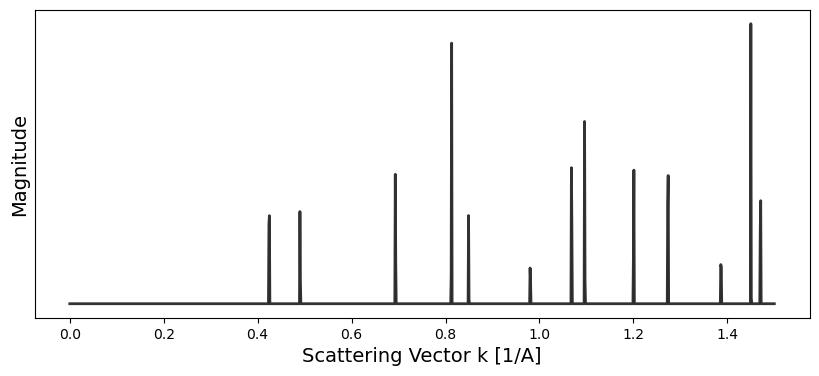

In [42]:
# Define gold structure 


# set lattice parameter and Z-number
a_lat = 4.08
atom_num = 79

# set max scattering angle, in inverse Angstroms
k_max = 1.5


# Define lattice
import numpy as np
pos = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.5, 0.5],
    [0.5, 0.0, 0.5],
    [0.5, 0.5, 0.0],
])

# Make crystal
crystal = py4DSTEM.process.diffraction.Crystal(
    pos, 
    atom_num, 
    a_lat)

# Calculate structure factors
crystal.calculate_structure_factors(k_max)

# Show
crystal.plot_scattering_intensity()

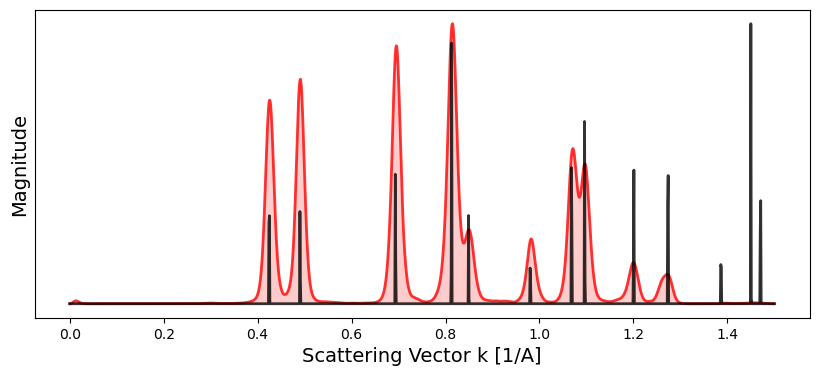

In [43]:
# Make an initial guess at the pixel size to refine
# Let's estimate eith an overlay of the measured scattering and reference crystal structure.


# Modify `pixel_size_inv_Ang_guess` until it 
# looks close before attempting to fit the data!
pixel_size_inv_Ang_guess = 0.02


# calibrate
braggpeaks.calibration.set_Q_pixel_size(pixel_size_inv_Ang_guess)
braggpeaks.calibration.set_Q_pixel_units('A^-1')
braggpeaks.setcal()

# show overlay
crystal.plot_scattering_intensity(
    bragg_peaks = braggpeaks,
    bragg_k_power = 2.0
)

Calibrated pixel size = 0.01995929 A^-1


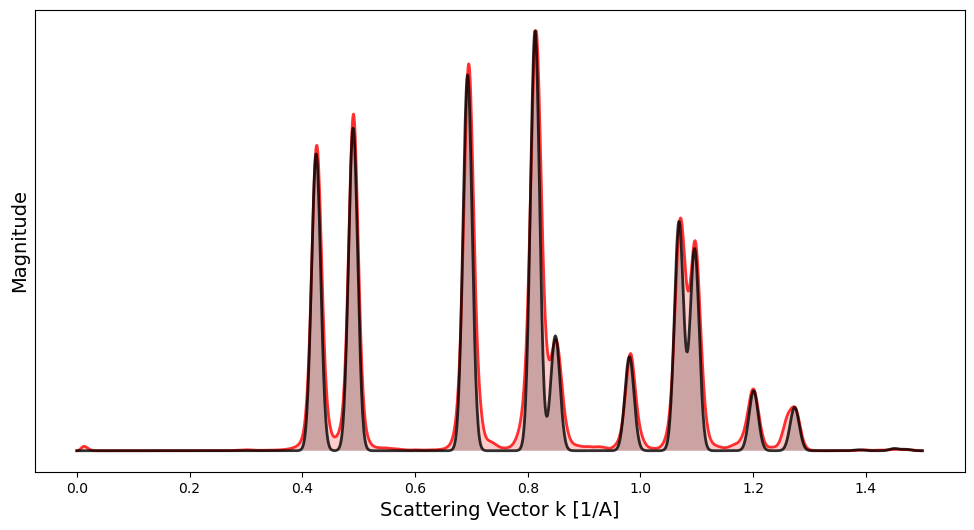

In [44]:
# fit pixel size to lattice

crystal.calibrate_pixel_size(
    bragg_peaks = braggpeaks,
    bragg_k_power = 2.0,
    plot_result = True,
);

In [45]:
braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:       0.02
             R_pixel_size:       1
             Q_pixel_units:      A^-1
             R_pixel_units:      pixels
             QR_flip:            False
             _root_treepath:     
             probe_semiangle:    5.14092564018049
             qx0_mean:           63.47416802294156
             qy0_mean:           63.22499601104463
             qx0_meas:           2D-array
             qy0_meas:           2D-array
             origin_meas_mask:   2D-array
             qx0:                2D-array
             qx0_shift:          2D-array
             qy0:                2D-array
             qy0_shift:          2D-array
             a:                  298.1941924997993
             b:                  278.2326703781001
             theta:              -2.1139796310061887
)

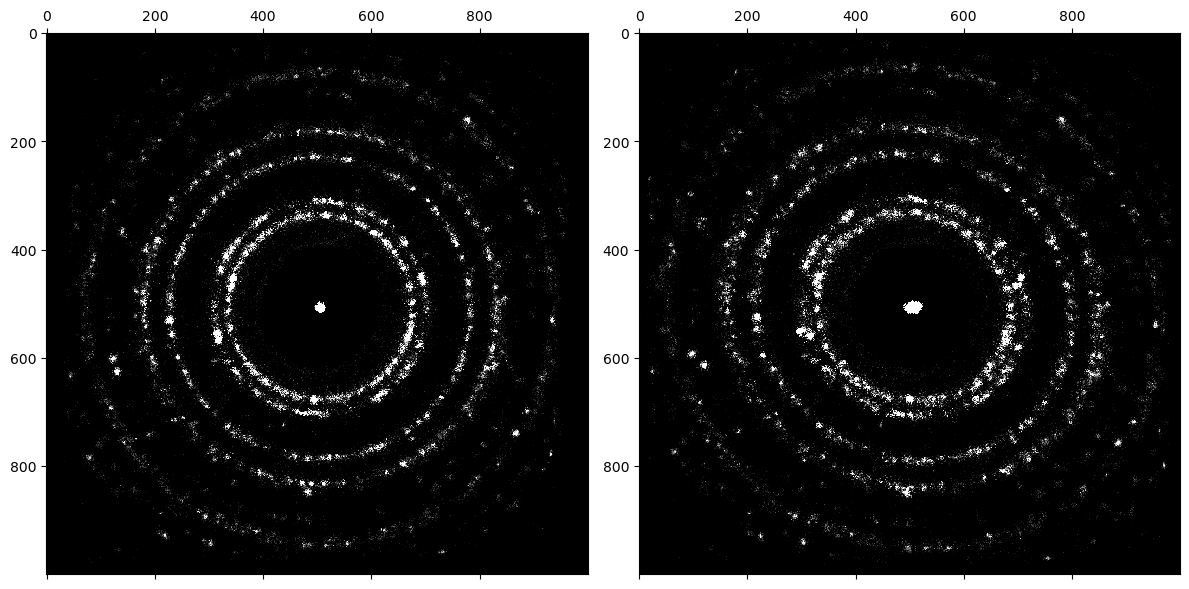

In [46]:
# New bvm, compare

braggpeaks.setcal()
bvm_p = braggpeaks.histogram(
    sampling=sampling
)

show([bvm_p, bvm_r],vmax=0.99)

In [47]:
bvm_p

BraggVectorMap( A 2-dimensional array of shape (1000, 1000) called '2Dhist_braggvectors_cal_s=8',
                with dimensions:

                    dim0 = [-1.2694833604588314,-1.2669833604588312,-1.2644833604588313,...] A^-1  (*non-linear*)
                    dim1 = [-1.2644999202208926,-1.2619999202208927,-1.2594999202208927,...] A^-1  (*non-linear*)
)

# Write and read

In [48]:
# set a filepath

filepath_basics_03 = dirpath + 'analysis_basics_03.h5'
filepath_basics_03

'/Users/Ben/work/data/py4DSTEM_sampleData/calibration_simulatedAuNanoplatelet/analysis_basics_03.h5'

In [49]:
# inspect what's in the data tree

basics_02.tree()

/
|---braggvectors
|---probe


In [50]:
# we can see above that the bragg vector map doesn't get added automatically to the tree.
# just for fun, let's do that now:

basics_02.tree(
    bvm_p
)

basics_02.tree()

/
|---braggvectors
|---probe
|---2Dhist_braggvectors_cal_s=8


In [51]:
# save

py4DSTEM.save(
    filepath_basics_03,
    basics_02,
    tree=None,
    mode = 'o'
)

100%|████████████████████████████████████████| 8400/8400 [00:02<00:00, 3973.51it/s]


In [52]:
# inspect the resulting HDF5 file

py4DSTEM.print_h5_tree(filepath_basics_03)

/
|---4DSTEM_simulation
    |---2Dhist_braggvectors_cal_s=8
    |---braggvectors
    |   |---_v_uncal
    |---probe




In [53]:
# read

d = py4DSTEM.read(
    filepath_basics_03,
)

Reading PointListArray: 100%|█████████| 8400/8400 [00:02<00:00, 3307.97PointList/s]


In [54]:
d.tree()

/
|---2Dhist_braggvectors_cal_s=8
|---braggvectors
|---probe


In [55]:
d.tree('braggvectors')

BraggVectors( A (100, 84)-shaped array of lists of bragg vectors )

In [56]:
# check that all the calibrations loaded correctly

d.tree('braggvectors').calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:       0.02
             R_pixel_size:       1
             Q_pixel_units:      A^-1
             R_pixel_units:      pixels
             QR_flip:            False
             _root_treepath:     
             a:                  298.1941924997993
             b:                  278.2326703781001
             origin_meas_mask:   2D-array
             probe_semiangle:    5.14092564018049
             qx0:                2D-array
             qx0_mean:           63.47416802294156
             qx0_meas:           2D-array
             qx0_shift:          2D-array
             qy0:                2D-array
             qy0_mean:           63.22499601104463
             qy0_meas:           2D-array
             qy0_shift:          2D-array
             theta:              -2.1139796310061887
)